<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/PytorchAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.optim import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [4]:
class MarketData:
    @classmethod
    def initialize(cls):
        cls.df = pd.DataFrame()
        cls.ts = []
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.vol = []
        cls.__read_data()
        cls.logopen = list(np.log(cls.open))
        cls.loghigh = list(np.log(cls.high))
        cls.loglow = list(np.log(cls.low))
        cls.logclose = list(np.log(cls.close))
        cls.close_change_ratio = list(np.array(pd.DataFrame(cls.close).pct_change().values.tolist()).reshape(len(cls.close)))
        cls.logclose_change_ratio = list(np.array(pd.DataFrame(cls.logclose).pct_change().values.tolist()).reshape(len(cls.logclose)))
    
    @classmethod
    def __read_data(cls):
        cls.df = pd.read_csv('/content/drive/My Drive/BTC-PERP-1mcp.csv')
        cls.ts = list(cls.df['ts'])
        cls.open = list(cls.df['open'])
        cls.high = list(cls.df['high'])
        cls.low = list(cls.df['low'])
        cls.close = list(cls.df['close'])
        cls.vol = list(cls.df['volume'])


MarketData.initialize()

In [30]:
####################################################################################
############################Generate Data#############################################
####################################################################################
class CustomDataset(Dataset):
    def __init__(self, from_ind, to_ind, data_length, sampling_window):
        self.input, self.output = self.__generate_data(from_ind, to_ind, data_length, sampling_window)
        
    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, index):
        #self.input = torch.tensor(self.input[index],dtype=torch.float32)
        #self.output = torch.tensor(self.self.output[index],dtype=torch.long)
        #self.input =self.input.to(device)
        #self.output =self.output.to(device)
        return torch.tensor(self.input[index], dtype=torch.float32), torch.tensor(self.output[index], dtype=torch.float32)
    
    def __generate_data(self, from_ind, to_ind, data_length, sampling_window):
        x = []
        y = []
        current_start = from_ind
        mmsc = MinMaxScaler(feature_range=(0,1), copy=True)
        while True:
            x.append(mmsc.fit_transform(np.array(MarketData.logclose[current_start : current_start + data_length]).reshape(-1,1)))
            y.append(mmsc.fit_transform(np.array(MarketData.logclose[current_start : current_start + data_length]).reshape(-1,1)))
            current_start += sampling_window
            if current_start >= to_ind:
                break
        return np.squeeze(x), np.squeeze(y)

transform = transforms.Compose([transforms.ToTensor()])
dataset = CustomDataset(1000000, 1300000, 30, 100)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
train_set = torch.utils.data.Subset(dataset, range(train_size))
val_set = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_set = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))
train_dataloader = DataLoader(train_set, batch_size=2100, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=64)
test_dataloader = DataLoader(test_set)
for X_batch, y_batch in train_dataloader:
    print(X_batch.shape, y_batch.shape)

torch.Size([2100, 30]) torch.Size([2100, 30])


In [36]:
class AutoEncoder(nn.Module):
    def __init__(self, seq_len):
        super(AutoEncoder, self).__init__()
        self.dense1 = nn.Linear(seq_len, seq_len)
        self.norm1 = nn.BatchNorm1d(seq_len)
        self.do1 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(seq_len, int(0.5 * seq_len))
        self.norm2 = nn.BatchNorm1d(int(0.5 * seq_len))
        self.do2 = nn.Dropout(0.2)
        self.dense3 = nn.Linear(int(0.5 * seq_len), int(0.5 * seq_len))
        self.norm3 = nn.BatchNorm1d(int(0.5 * seq_len))
        self.dense4 = nn.Linear(int(0.5 * seq_len), seq_len)
        self.do3 = nn.Dropout(0.2)
        self.norm4 = nn.BatchNorm1d(seq_len)
        self.dense5 = nn.Linear(seq_len, seq_len)

    '''
    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            nn.init.kaiming_normal_(module.weight)
    '''

    def forward(self, input):
        output = F.leaky_relu(self.dense1(input))
        output = self.norm1(output)
        output = self.do1(output)
        output = F.leaky_relu(self.dense2(output))
        output = self.norm2(output)
        output = self.do2(output)
        #output = F.relu(self.dense3(output))
        #output = self.norm3(output)
        output = F.softmax(self.dense4(output))
        #output = self.do3(output)
        #output = self.norm4(output)
        #output = F.softmax(self.dense5(output))
        return output

model = AutoEncoder(30)
for name, param in model.named_parameters():
    if 'bias' in name:
        nn.init.constant_(param, 0.0)
    elif 'dense' in name:
        nn.init.kaiming_uniform_(param)
    elif 'weight_hh' in name:
        nn.init.orthogonal_(param)
print(model)

AutoEncoder(
  (dense1): Linear(in_features=30, out_features=30, bias=True)
  (norm1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do1): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=30, out_features=15, bias=True)
  (norm2): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do2): Dropout(p=0.2, inplace=False)
  (dense3): Linear(in_features=15, out_features=15, bias=True)
  (norm3): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense4): Linear(in_features=15, out_features=30, bias=True)
  (do3): Dropout(p=0.2, inplace=False)
  (norm4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense5): Linear(in_features=30, out_features=30, bias=True)
)


In [37]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

cpu
Epoch: 1/400, Loss: 0.30669140815734863
Epoch: 2/400, Loss: 0.30419105291366577
Epoch: 3/400, Loss: 0.3025234639644623
Epoch: 4/400, Loss: 0.3012576997280121


<ipython-input-36-7edf48ef7b3b>:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.dense4(output))


Epoch: 5/400, Loss: 0.30025163292884827
Epoch: 6/400, Loss: 0.29919204115867615
Epoch: 7/400, Loss: 0.2982890009880066
Epoch: 8/400, Loss: 0.2975497245788574
Epoch: 9/400, Loss: 0.29666659235954285
Epoch: 10/400, Loss: 0.296030730009079
Epoch: 11/400, Loss: 0.2952996790409088
Epoch: 12/400, Loss: 0.29482340812683105
Epoch: 13/400, Loss: 0.2943039834499359
Epoch: 14/400, Loss: 0.2938847839832306
Epoch: 15/400, Loss: 0.2933707535266876
Epoch: 16/400, Loss: 0.29297125339508057
Epoch: 17/400, Loss: 0.29267439246177673
Epoch: 18/400, Loss: 0.29237574338912964
Epoch: 19/400, Loss: 0.29200291633605957
Epoch: 20/400, Loss: 0.29182520508766174
Epoch: 21/400, Loss: 0.29140356183052063
Epoch: 22/400, Loss: 0.2911975681781769
Epoch: 23/400, Loss: 0.2909816801548004
Epoch: 24/400, Loss: 0.29071661829948425
Epoch: 25/400, Loss: 0.29050442576408386
Epoch: 26/400, Loss: 0.2901831865310669
Epoch: 27/400, Loss: 0.2901000380516052
Epoch: 28/400, Loss: 0.2899415194988251
Epoch: 29/400, Loss: 0.28971451520

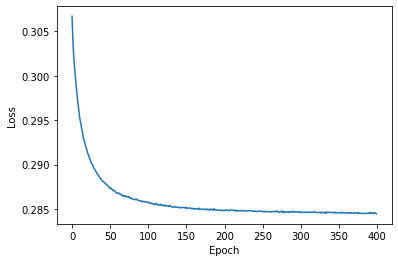

In [38]:
loss_history = []
acc_history = []
num_epochs = 400

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Train the model for a number of epochs
for epoch in range(num_epochs):
    # Initialize variables to store the average loss and accuracy for the epoch
    avg_loss = 0.0
    count = 0
    loss_sum = 0
    # Iterate through the data
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute the loss
        loss = loss_fn(outputs, labels)
        loss_sum += loss.item()
        # Backward pass
        loss.backward()
        #update weights
        optimizer.step()

        count += 1
        # Append the loss and accuracy to the history
        loss_history.append(loss_sum / len(train_dataloader))
    # Print the loss and accuracy for the epoch
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss_sum / len(train_dataloader)}")
torch.save(model.state_dict(), './pytorch_model') 



# Plot the loss and accuracy history
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


<ipython-input-36-7edf48ef7b3b>:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(self.dense4(output))


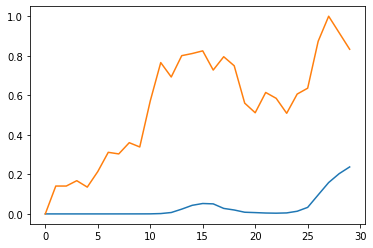

In [39]:
'''
Sets the module in evaluation mode.
This has any effect only on certain modules. See documentations of particular modules for details of their behaviors in training/evaluation mode, if they are affected, e.g. Dropout, BatchNorm, etc.
This is equivalent with self.train(False).
'''
model.eval()
with torch.no_grad(): 
    for x, y in test_dataloader:
        plt.plot(np.squeeze(model(x).detach().numpy().copy()))
        plt.plot(np.squeeze(y.detach().numpy().copy()))
        break

In [19]:
for name, param in model.named_parameters():
    nn.init.constant_(param, 0.0)

In [20]:
for name, param in model.named_parameters():
    print(param)

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
     

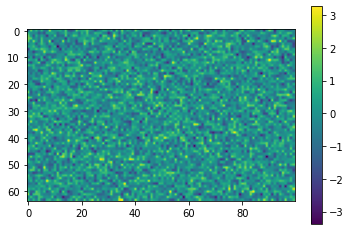

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
values = output_bn.flatten()

# Extract the dimensions of the tensor
values = output_bn.detach().numpy()

# Create a figure and a subplot
fig, ax = plt.subplots()

# Create a heatmap
im = ax.imshow(values)

# Add a colorbar
fig.colorbar(im)

# Show the plot
plt.show()

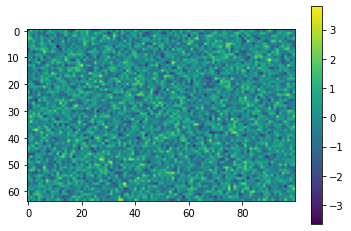

In [ ]:
values = output_bn.flatten()

# Extract the dimensions of the tensor
values = output_ln.detach().numpy()

# Create a figure and a subplot
fig, ax = plt.subplots()

# Create a heatmap
im = ax.imshow(values)

# Add a colorbar
fig.colorbar(im)

# Show the plot
plt.show()

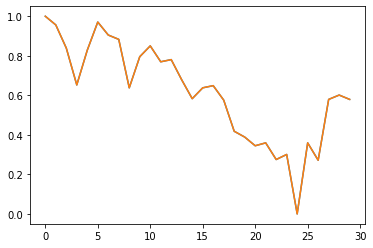

In [ ]:
for inputs, labels in train_dataloader:
    plt.plot(inputs[10])
    plt.plot(labels[10])
    break

In [ ]:
for X_batch, y_batch in train_dataloader:
    print(X＿batch.to(torch.float32).size())

torch.Size([64, 1440, 1])
torch.Size([41, 1440, 1])


In [ ]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [ ]:
input

tensor([[ 0.5494, -0.4853,  0.0297, -0.3756, -0.6586],
        [ 0.0701,  0.4216, -0.0351,  0.4656,  1.3406],
        [ 0.1738, -0.0136, -1.9101, -0.9687,  1.2953]], requires_grad=True)